In [7]:
from seligator.common.params import MetadataEncoding, Seq2VecEncoderType, BasisVectorConfiguration
from seligator.main import train_and_get, Seligator
from seligator.common.load_save import load
from seligator.prediction.tests import run_tests

from seligator.models.siamese import SiameseClassifier
from seligator.models.classifier import FeatureEmbeddingClassifier
import os
import json
import logging

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

def get_json_fn(fn):
    return f"dumped-results/{fn}.json"

def already_done(fn):
    return os.path.exists(get_json_fn(fn))

def save_json(fn, obj):
    with open(get_json_fn(fn), "w") as f:
        json.dump(obj, f)


# Run tests on Vectors Categories
def get_kwargs():
    METADATA_CATS = ("Century", "Textgroup", "WrittenType", "CitationTypes")
    BVC = BasisVectorConfiguration(
        categories=METADATA_CATS
    )
    return dict(
        token_features=("lemma_char", "lemma"),
        msd_features=("case", "numb", "gend", "mood", "tense", "voice", "person", "deg"),
        seq2vec_encoder_type=Seq2VecEncoderType.LSTM,
        basis_vector_configuration=BVC,
        agglomerate_msd=False,
        reader_kwargs={
            "batch_size": 4, 
            "metadata_encoding": MetadataEncoding.IGNORE,
            "metadata_tokens_categories": METADATA_CATS
        },
        model_embedding_kwargs=dict(
            keep_all_vocab=True,
            pretrained_embeddings={
                # "token": "~/Downloads/latin.embeddings",
            #    "token": "~/dev/these/notebooks/4 - Detection/data/embs_models/model.token.word2vec.kv",
            #    "lemma": "~/dev/these/notebooks/4 - Detection/data/embs_models/model.lemma.word2vec.kv.header"
            },
            trainable_embeddings={"token": False, "lemma": False},
            emb_dims={"token": 200, "lemma": 200}
        ),
        encoder_hidden_size=64,
        batches_per_epoch=None,
        model_class=FeatureEmbeddingClassifier,
        use_bert_highway=False,
        bert_dir = "./bert/latin_bert"
    )

    
def get_train_and_get_kwargs():
    return dict(patience=4, num_epochs=20, lr=5e-4, optimizer="AdamW")

def jqs(data):
    return "-".join(sorted(list(data)))

def get_filename(params, prefix = "model"):
    remaped = []
    for key in sorted(list(params.keys())):
        if isinstance(params[key], str) and not params[key]:
            continue
        if isinstance(params[key], str) and "-" in params[key]:
            remaped.append(f"{key}-"+"".join([
                "".join([
                    subv[:3].lower().capitalize()
                    for subv in v.split("_")
                ])
                for v in params[key].split("-")
            ]))
        else:
            remaped.append(f"{key}-{params[key]}")
    print(remaped)
    return prefix+"--"+"__".join(remaped)

def merge(source, destination):
    """ Source = New , Destination = Default
    run me with nosetests --with-doctest file.py

    >>> a = { 'first' : { 'all_rows' : { 'pass' : 'dog', 'number' : '1' } } }
    >>> b = { 'first' : { 'all_rows' : { 'fail' : 'cat', 'number' : '5' } } }
    >>> merge(b, a) == { 'first' : { 'all_rows' : { 'pass' : 'dog', 'fail' : 'cat', 'number' : '5' } } }
    True
    """
    for key, value in source.items():
        if isinstance(value, dict):
            # get node or create one
            node = destination.setdefault(key, {})
            merge(value, node)
        else:
            destination[key] = value

    return destination

def run_and_save(model_name, prepare_model_kwargs, train_kwargs, model_name_prefix: str = "model"):
    fn = f"{model_name_prefix}-{model_name}"
    
    if already_done(fn):
        print(f"Already trained {fn}")
        return {}
    
    seligator, reader, train, dev = Seligator.init_from_params(
        **prepare_model_kwargs
    )
    _ = train_and_get(seligator.model, train, dev, **train_kwargs)
    seligator.save_model(f"./models/{fn}")
    data, img = run_tests(
        "dataset/main/test.txt",
        dataset_reader=reader, model=seligator.model, dump=f"./models/{fn}/test.csv"
    )
    out = {
        fn: {
            **{x:v for x, v in data.items() if isinstance(v, float)},
            **train_kwargs
        }
    }
    save_json(fn, out)
    return out

def get_siamese():
    siamese = get_kwargs()
    siamese["model_class"] = SiameseClassifier
    siamese["batches_per_epoch"] = 20
    siamese_train_kwargs = get_train_and_get_kwargs()
    siamese_train_kwargs["num_epochs"] = siamese_train_kwargs["num_epochs"] * int(1351 // siamese["batches_per_epoch"])
    siamese_train_kwargs["patience"] = 10
    return siamese, siamese_train_kwargs

def get_classic():
    return get_kwargs(), get_train_and_get_kwargs()

RUNS = {}

In [8]:
# Check what can be JSONIFIED

import json

# https://stackoverflow.com/questions/24481852/serialising-an-enum-member-to-json

class CustomEncoder(json.JSONEncoder):
    _PUBLIC_ENUMS = {
        "MetadataEncoding": MetadataEncoding, 
        "Seq2VecEncoderType": Seq2VecEncoderType, 
        #"BasisVectorConfiguration": BasisVectorConfiguration
    }
    _PUBLIC_CLASSES = {
        "SiameseClassifier": SiameseClassifier,
        "FeatureEmbeddingClassifier": FeatureEmbeddingClassifier
    }

    def default(self, obj):
        if type(obj) in CustomEncoder._PUBLIC_ENUMS.values():
            return {"__enum__": str(obj)}
        elif isinstance(obj, type):
            if obj in CustomEncoder._PUBLIC_CLASSES.values():
                return {"__type__": str(obj.__name__)}
            else:
                print(obj)
        elif isinstance(obj, BasisVectorConfiguration):
            return {"__basis_vector_configuration__": obj.to_dict()}
        return json.JSONEncoder.default(self, obj)

    @staticmethod
    def object_hook(d):
        if "__enum__" in d:
            name, member = d["__enum__"].split(".")
            return getattr(CustomEncoder._PUBLIC_ENUMS[name], member)
        elif "__type__" in d:
            return CustomEncoder._PUBLIC_CLASSES[d["__type__"]]
        elif "__basis_vector_configuration__" in d:
            return BasisVectorConfiguration.from_dict(d["__basis_vector_configuration__"])
        else:
            return d


PRE_LEMMA = {
    "model_embedding_kwargs":{
        "pretrained_embeddings": {
            "lemma": "~/dev/these/notebooks/4 - Detection/data/embs_models/model.lemma.word2vec.kv.header"
        }
    }
}

In [11]:
def do_runs(get_kw, has_linear=False):
    if has_linear:
        name = lambda string: "Linear"+string
    else:
        name = lambda string: "Siamese"+string
        
    NoAuthor_METADATA_CATS = ("Century", "WrittenType", "CitationTypes")
    NoAuthor_BVC = BasisVectorConfiguration(
        categories=NoAuthor_METADATA_CATS
    )
    
    PRE_LEMMA = {
        "model_embedding_kwargs":{
            "pretrained_embeddings": {
                "lemma": "~/dev/these/notebooks/4 - Detection/data/embs_models/model.lemma.word2vec.kv.header"
            }
        }
    }
    Changes = [
        # Use raw Bert
        (name("BertTokenOnly"), {"token_features": ("token_subword", )}, {}),
        # Use raw Bert No Highway
        (name("BertTokenOnlyWithHighway"), {"token_features": ("token_subword", ), "use_bert_highway": True}, {}),
        # Use raw Bert + Lemma
        (name("BertLemma-HAN"), {
            "token_features": ("token_subword", "lemma", "lemma_char"),
            "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
            "use_bert_highway": False
        }, {}),
        (name("Vanilla"), {}, {}),
        # Raw Features + MSD + Vanilla LSTM
        (name("VanillaAggloMSD"), {"agglomerate_msd": True}, {}),
        # Raw Features + MSD + HAN
        (name("VanillaAggloMSD-HAN"), {"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.HAN}, {}),
        # Raw Features + MSD + Enriched LSTM
        (name("VanillaAggloMSD-EnriLSTM"),
         {"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.MetadataLSTM,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL}}, {}),
        # Raw Features + MSD + Enriched Attention
        (name("VanillaAggloMSD-EnriAttention"),
         {"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.MetadataAttentionPooling,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL}}, {}),
        # Raw Features + MSD + Attention
        (name("VanillaAggloMSD-AttentPool"),
         {"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.AttentionPooling,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL}}, {}),
        # Now we use Metadata Tokens !
        # Raw Features + MSD + Attention
        #({ # Does not work because AttentionPooling expects metadata_vector
        #    "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_TOKEN},
        #    "agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.AttentionPooling}, {}),
        # Raw Features + MSD + Attention
        (name("VanillaAggloMSD-Metatoks-HAN"),
         {
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_TOKEN},
            "agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.HAN}, {}),
        #
        #
        # With Pretrained
        #
        #
        # Raw Features + MSD + Vanilla LSTM
        (name("VanillaAggloMSD-Pretrained"), {"agglomerate_msd": True, **PRE_LEMMA}, {}),
        # Raw Features + MSD + HAN
        (name("VanillaAggloMSD-HAN-Pretrained"), {"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
          **PRE_LEMMA}, {}),
        # Raw Features + MSD + Enriched LSTM
        (name("VanillaAggloMSD-EnriLSTM-Pretrained"), 
         {"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.MetadataLSTM,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
          **PRE_LEMMA}, {}),
        # Raw Features + MSD + Enriched Attention
        (name("VanillaAggloMSD-EnriAttention-Pretrained"), 
         {"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.MetadataAttentionPooling,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
          **PRE_LEMMA}, {}),
        # Raw Features + MSD + Attention
        (name("VanillaAggloMSD-AttentPool-Pretrained"), 
         {"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.AttentionPooling,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
          **PRE_LEMMA}, {}),
    ]
    if has_linear:
        Changes = Changes + [
            (
                name("Vanilla-LinearEnriched"), 
                 {
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True}
            }, {}),
            (
                name("Vanilla-LinearEnriched-Pretrained"), 
                {
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}),
            (
                name("VanillaAggloMSD-HAN-LinearEnriched-Pretrained"), 
                {"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}),
            (
                name("VanillaAggloMSD-EnriLSTM-LinearEnriched-Pretrained"), 
                {"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.MetadataLSTM,
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}),
            # Apparently, its the best, so let's play with input features
            # ("lemma_char", "lemma", "case", "numb", "gend", "mood", "tense", "voice", "person", "deg")
            (
                name("Vanilla-NoMorph-HAN-LinearEnriched-Pretrained"), 
                {"token_features": ("lemma_char", "lemma"), #No morph
              "agglomerate_msd": False, "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}
            ),
            # No Author in metadata
            (
                name("Vanilla-NoMorph-HAN-LinearEnriched-Pretrained-NoAuthor"), 
                {
                    "token_features": ("lemma_char", "lemma"), #No morph
                    "agglomerate_msd": False,
                    "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
                    "reader_kwargs": {
                        "metadata_encoding": MetadataEncoding.AS_CATEGORICAL,
                        "metadata_tokens_categories": NoAuthor_METADATA_CATS
                    },
                    "basis_vector_configuration": NoAuthor_BVC,
                    "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}),
        ]
    for idx, (model_name, model_kw, train_kw) in enumerate(Changes):
        defaults_model, default_trains = get_kw()
        model_kw = merge(model_kw, defaults_model)
        train_kw = merge(train_kw, default_trains)
        RUNS.update(run_and_save(model_name, model_kw, train_kw, model_name_prefix=f"model-"))

# Siamese Networks

Already trained model--LinearBertTokenOnly
Already trained model--LinearBertTokenOnlyWithHighway
Already trained model--LinearBertLemma-HAN
Already trained model--LinearVanilla
Already trained model--LinearVanillaAggloMSD
Already trained model--LinearVanillaAggloMSD-HAN
Already trained model--LinearVanillaAggloMSD-EnriLSTM
Already trained model--LinearVanillaAggloMSD-EnriAttention
Already trained model--LinearVanillaAggloMSD-AttentPool
Already trained model--LinearVanillaAggloMSD-Metatoks-HAN
Already trained model--LinearVanillaAggloMSD-Pretrained
Already trained model--LinearVanillaAggloMSD-HAN-Pretrained
Already trained model--LinearVanillaAggloMSD-EnriLSTM-Pretrained
Already trained model--LinearVanillaAggloMSD-EnriAttention-Pretrained
Already trained model--LinearVanillaAggloMSD-AttentPool-Pretrained
Already trained model--LinearVanilla-LinearEnriched
Already trained model--LinearVanilla-LinearEnriched-Pretrained
Already trained model--LinearVanillaAggloMSD-HAN-LinearEnriched-Pretr

/home/thibault/dev/est-lascivuum-non-est/env/lib/python3.8/site-packages/allennlp/data/token_indexers/token_characters_indexer.py:55: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  warnings.warn(


building vocab:   0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/155131 [00:00<?, ?it/s]

---> Epochs:   20
---> Patience: 4


/home/thibault/dev/est-lascivuum-non-est/env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/1357 [00:00<?, ?it/s]

/home/thibault/dev/est-lascivuum-non-est/seligator/models/classifier.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

Evaluating


0it [00:00, ?it/s]

Evaluating: Predicting


/home/thibault/dev/est-lascivuum-non-est/seligator/prediction/tests.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  disp.figure_.show()
/home/thibault/dev/est-lascivuum-non-est/env/lib/python3.8/site-packages/allennlp/data/token_indexers/token_characters_indexer.py:55: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  warnings.warn(


False ('lemma_char', 'lemma')
GetMeBert(use_bert=False, embedder=None, indexer=None, tokenizer=None)


building vocab:   0%|          | 0/5427 [00:00<?, ?it/s]

ERROR:allennlp.data.vocabulary:Namespace: Textgroup_ns_labels
ERROR:allennlp.data.vocabulary:Token: urn:cts:latinLit:phi1236


KeyError: "'urn:cts:latinLit:phi1236' not found in vocab namespace 'Textgroup_ns_labels', and namespace does not contain the default OOV token ('@@UNKNOWN@@')"

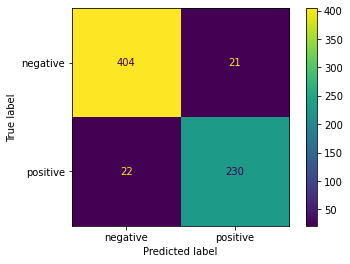

In [12]:
do_runs(get_classic, has_linear=True)

In [ ]:
import glob
RUNS = []
for file in glob.glob("dumped-results/*.json"):
    with open(file) as f:
        RUNS.append(json.load(f))

In [ ]:
best, best_key = 0, None
sorts = sorted([(list(run.keys())[0], list(run.values())[0]["accuracy"]) for run in RUNS], key=lambda x: x[1])
for key in sorts:
    print(key[0], key[1])